# 나의 첫 번째 캐글 경진대회, 무작정 따라해보기
https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr

## 목표

#### 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
#### 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
#### 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

In [241]:
#베이스라인 파일에서 시작을 해보겠습니다


import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import cv2 as cv

%matplotlib inline  

In [242]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [243]:
#sub가 prediction에 쓸 데이터 부분이 되겠습니다

data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [244]:
#예측해야 할 정보가 price라 원래 데이터테이블에서 분리하여 따로 관리

y = data['price']
del data['price']

In [245]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [246]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

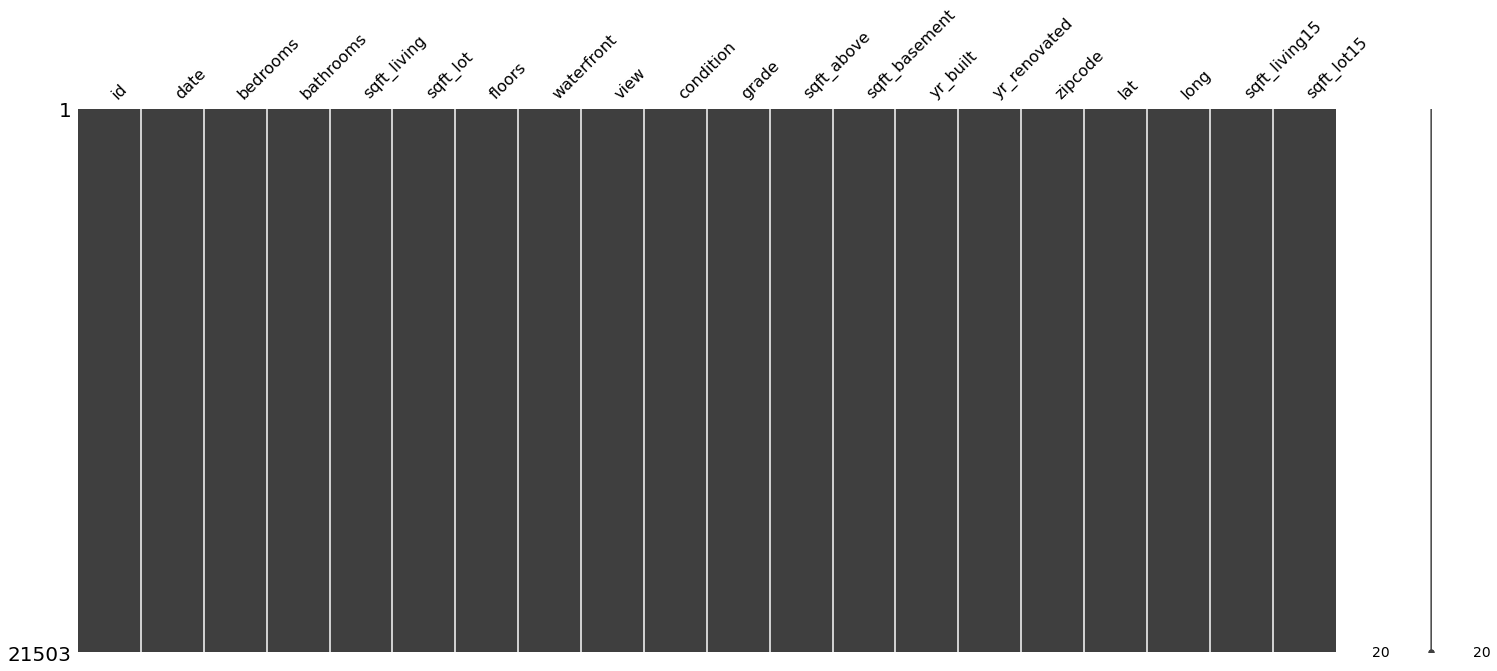

In [247]:
msno.matrix(data)

#결측치가 있다면 흰 점이 나타난다고 했습니다

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [248]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [249]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : (x[:6])).astype(int)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

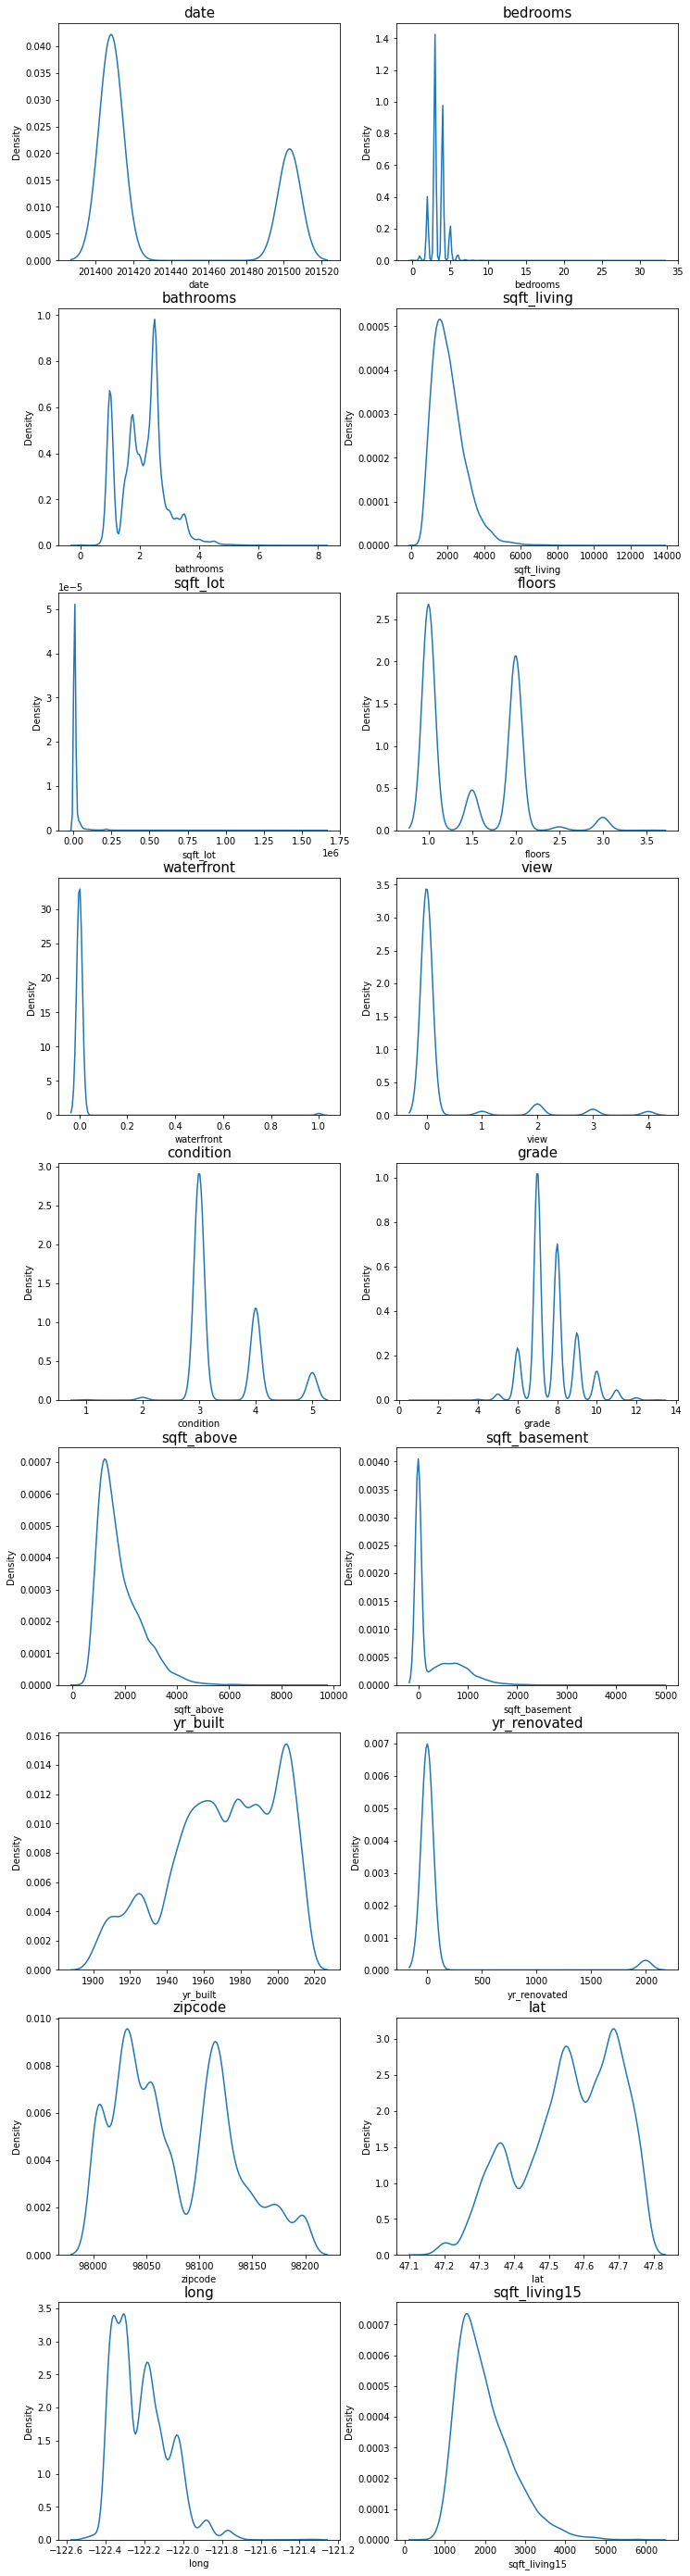

In [250]:
'''

fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break
            
#원코드가 에러가 났다 대체왜죠
# kdeplot 함수에서 TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required
'''
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break
            
#이 코드는 node에서 가져온 코드
#차이점이라면 원 baseline kernel에는 date함수를 그렸지만, 여기서는 그리지 않았음
#결국 처음 에러는, datetime를 그리려고 해서 나왔던 에러였던것임

#이부분은 위에 date처리를 astype(int)로 바꾸면서 다시 date를 쓰게 되었습니다

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [251]:
#'sqft_lot15', 'sqft_living15' 두 변수는 베이스라인에 포함되어있지 않지만, 노드의 내용에는 포함이 되어있다
#노드의 내용을 따라가볼게요


skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)


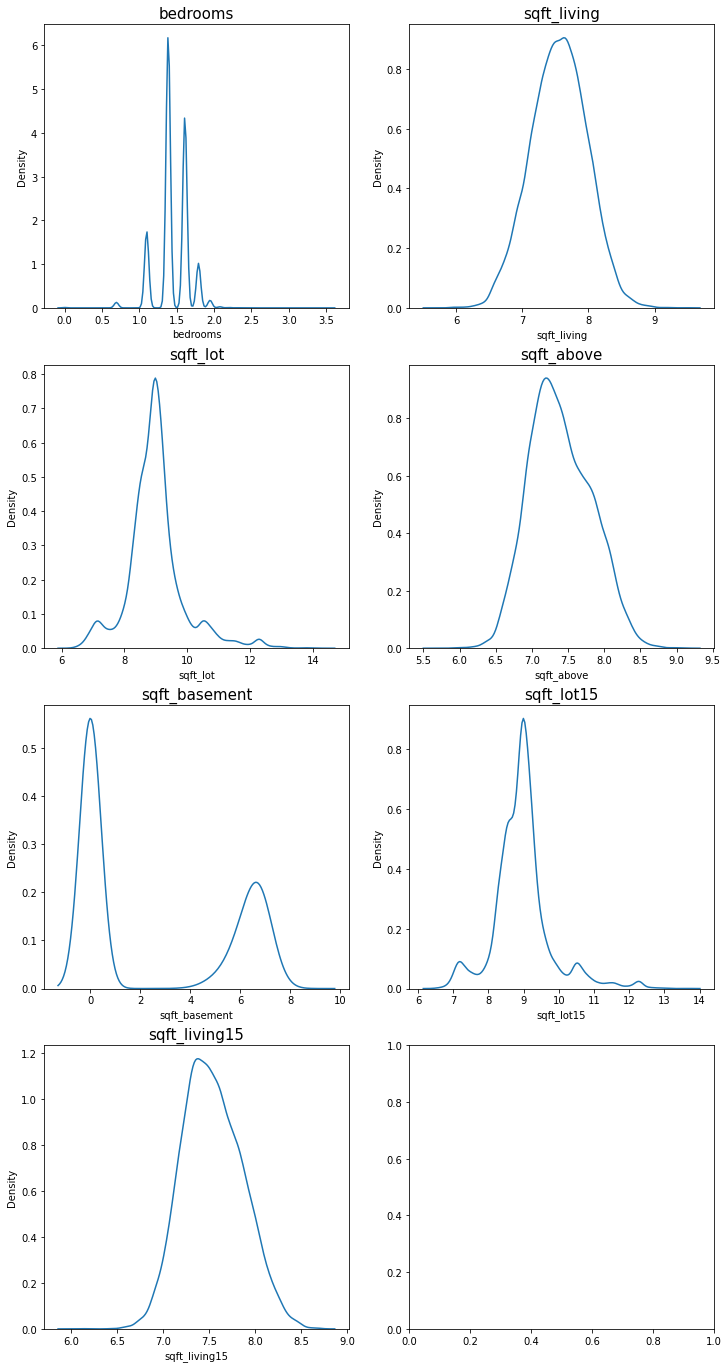

In [252]:

fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [253]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


### 각 변수들의 분포 확인 추가 사항
가격도 분포를 파악해보기

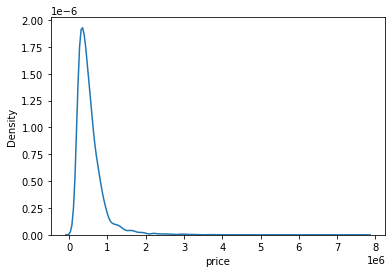

In [254]:
sns.kdeplot(data=y)
plt.show()

치우침이 확인됨에 따라 y는 np.log1p() 함수를 통해 로그 변환을 해주고, 나중에 모델이 값을 예측한 후에 다시 np.expm1()을 활용해서 되돌리겠습니다

In [255]:
y = np.log1p(y)

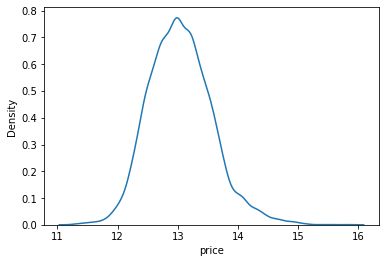

In [256]:

sns.kdeplot(y)
plt.show()

### 가격과 각 특성의 상관관계 분석
직관적으로 파악하기위해 그래프로 그려본 후, 상관계수를 구해서 각 특성과 가격의 상관순위를 정해봅니다

In [257]:
x.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [258]:
x['date']

0        201410
1        201502
2        201502
3        201406
4        201501
          ...  
15030    201410
15031    201503
15032    201405
15033    201502
15034    201410
Name: date, Length: 15035, dtype: int64

<AxesSubplot:xlabel='grade', ylabel='price'>

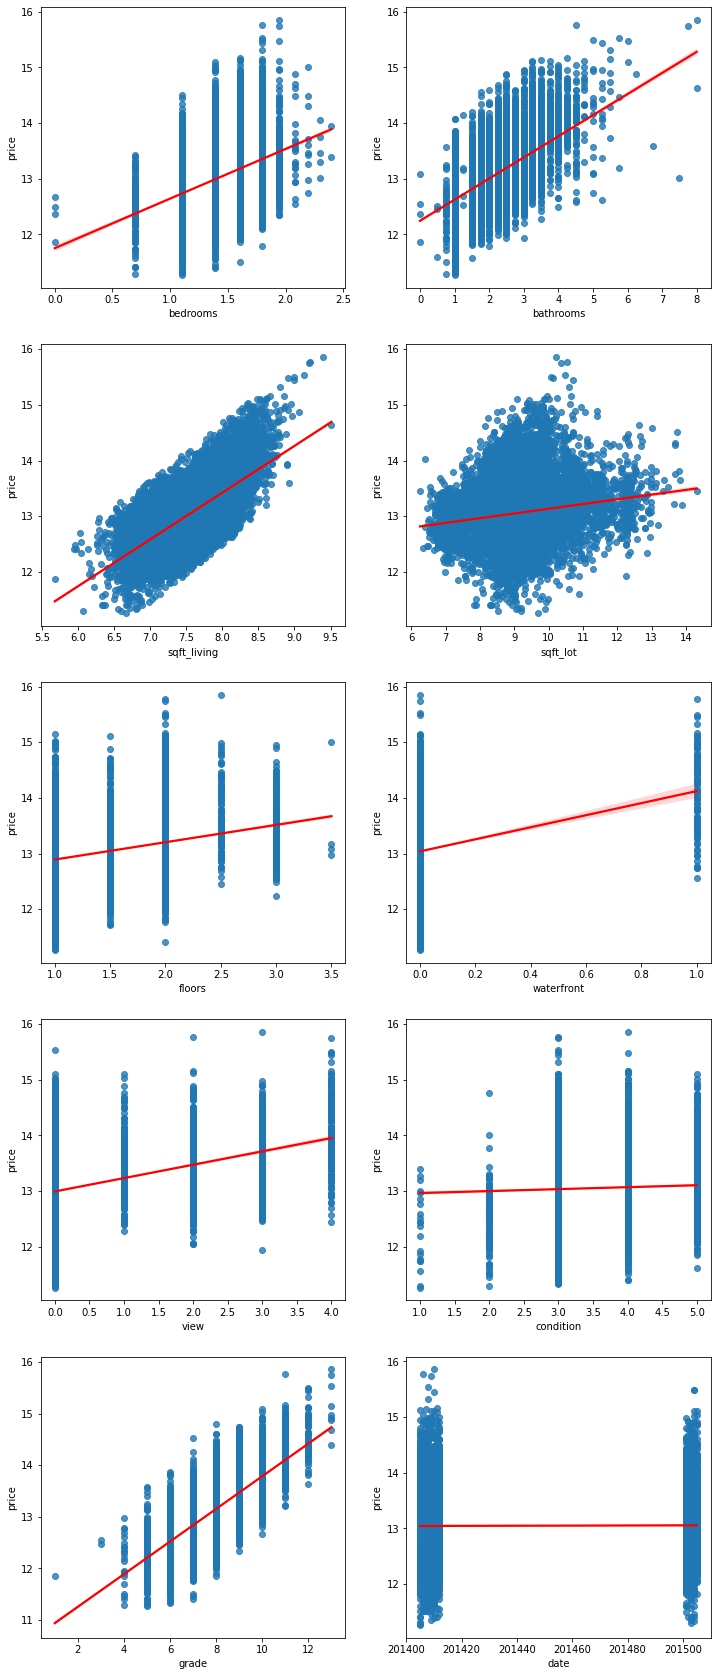

<Figure size 1440x1440 with 0 Axes>

In [259]:
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax0)) = plt.subplots(nrows = 5, ncols=2)
figure.set_size_inches(12, 30)


plt.figure(figsize=(20,20))
sns.regplot(x = x[x.columns[0]], y = y, ax = ax0, line_kws={'color':"red"}) 
sns.regplot(x = x[x.columns[1]], y = y, ax = ax1, line_kws={'color':"red"}) 
sns.regplot(x = x[x.columns[2]], y = y, ax = ax2, line_kws={'color':"red"}) 
sns.regplot(x = x[x.columns[3]], y = y, ax = ax3, line_kws={'color':"red"}) 
sns.regplot(x = x[x.columns[4]], y = y, ax = ax4, line_kws={'color':"red"}) 
sns.regplot(x = x[x.columns[5]], y = y, ax = ax5, line_kws={'color':"red"}) 
sns.regplot(x = x[x.columns[6]], y = y, ax = ax6, line_kws={'color':"red"}) 
sns.regplot(x = x[x.columns[7]], y = y, ax = ax7, line_kws={'color':"red"}) 
sns.regplot(x = x[x.columns[8]], y = y, ax = ax8, line_kws={'color':"red"}) 
sns.regplot(x = x[x.columns[9]], y = y, ax = ax9, line_kws={'color':"red"}) 




<AxesSubplot:xlabel='sqft_lot15', ylabel='price'>

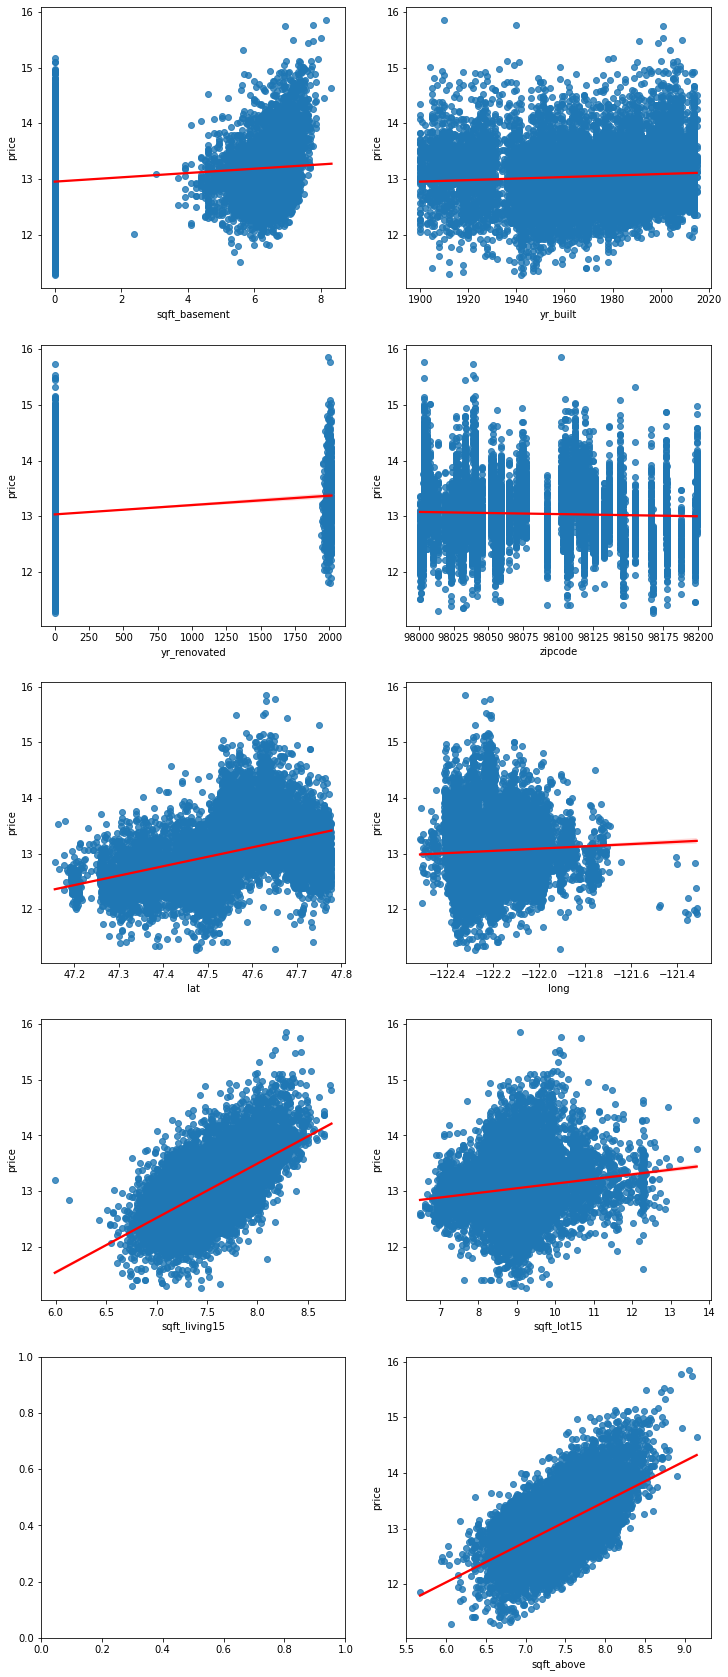

In [260]:
figure, ((ax11, ax12), (ax13, ax14), (ax15, ax16), (ax17, ax18), (ax10, ax10 )) = plt.subplots(nrows = 5, ncols=2)
figure.set_size_inches(12, 30)

sns.regplot(x = x[x.columns[10]], y = y, ax = ax10, line_kws={'color':"red"}) 
sns.regplot(x = x[x.columns[11]], y = y, ax = ax11, line_kws={'color':"red"}) 
sns.regplot(x = x[x.columns[12]], y = y, ax = ax12, line_kws={'color':"red"}) 
sns.regplot(x = x[x.columns[13]], y = y, ax = ax13, line_kws={'color':"red"}) 
sns.regplot(x = x[x.columns[14]], y = y, ax = ax14, line_kws={'color':"red"}) 
sns.regplot(x = x[x.columns[15]], y = y, ax = ax15, line_kws={'color':"red"}) 
sns.regplot(x = x[x.columns[16]], y = y, ax = ax16, line_kws={'color':"red"}) 
sns.regplot(x = x[x.columns[17]], y = y, ax = ax17, line_kws={'color':"red"}) 
sns.regplot(x = x[x.columns[18]], y = y, ax = ax18, line_kws={'color':"red"}) 


특성과 가격의 반비례 관계는 없어보임 혹은 미미함

가정 1 - 상관관계가 없는 특성이 존재한다 (날짜 위도 경도)
날짜는 상관관계가 없을거라고 생각하여 비교하지 않음
위도 / 경도 등은 집값에 끼치는 영향에 관계가 없을것이라 생각했지만 그래프에 기울기가 있다

가정 2 - 반비례 관계가 존재한다 (건축년도)
기울기가 매우 미비함

상관계수까지 구할 수 있어야, 관계를 확실하게 알 수 있을것 같다

In [261]:
cor_test = x
cor_test['price'] = y
cor_test.corr()['price'].sort_values()

zipcode         -0.039195
date             0.009466
condition        0.042947
long             0.054362
yr_built         0.076293
yr_renovated     0.127533
sqft_lot15       0.128528
sqft_lot         0.145465
waterfront       0.172580
sqft_basement    0.231982
floors           0.317810
view             0.347506
bedrooms         0.356086
lat              0.444417
bathrooms        0.552000
sqft_above       0.591185
sqft_living15    0.609042
sqft_living      0.677383
grade            0.707412
price            1.000000
Name: price, dtype: float64

https://ko.wikipedia.org/wiki/%EC%83%81%EA%B4%80_%EB%B6%84%EC%84%9D

상관분석에 있어 일반적으로 상관계수가

r이 -1.0과 -0.7 사이이면, 강한 음적 선형관계,  
r이 -0.7과 -0.3 사이이면, 뚜렷한 음적 선형관계,  
r이 -0.3과 -0.1 사이이면, 약한 음적 선형관계,  
r이 -0.1과 +0.1 사이이면, 거의 무시될 수 있는 선형관계,  
r이 +0.1과 +0.3 사이이면, 약한 양적 선형관계,  
r이 +0.3과 +0.7 사이이면, 뚜렷한 양적 선형관계,  
r이 +0.7과 +1.0 사이이면, 강한 양적 선형관계  
로 해석한다.  
  
고 한다  

따라서 상관도가 거의 없는  

date             0.009466  
zipcode         -0.039195  
condition        0.042947  
long             0.054362  
yr_built         0.076293  
는 무시  
  
나머지 요소에 가중치/패널티를 줄 수 있을지 확인을 해봐야 할것 같습니다  

그룹은 3개  
  
패널티그룹  
  
yr_renovated     0.127533  
sqft_lot15       0.128528  
sqft_lot         0.145465  
waterfront       0.172580  
sqft_basement    0.231982  
  
일반그룹  
  
floors           0.317810  
view             0.347506  
bedrooms         0.356086  
lat              0.444417  
bathrooms        0.552000  
sqft_above       0.591185  
sqft_living15    0.609042  
sqft_living      0.677383  
  
가중치그룹  
  
grade            0.707412  

에 따라 준비하도록 한다

In [262]:
#del x['date']
#del x['zipcode']
#del x['condition']
#del x['long']
#del x['yr_built']
#x

In [263]:
#위에 x에 y값으로 들어갈 price가 들어간건
#중간 cor_test = x
# cor_test['price'] = y
#할때 deepcopy로 다른 객체를 만들어주지 않아서 x에 다시 붙은듯
#제거합니다
del x['price']
x

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.000000,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.000000,1963,0,98198,47.4095,-122.315,7.409136,9.181118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,1.609438,2.50,7.832411,8.703507,2.0,0,0,3,9,7.832411,0.000000,2014,0,98056,47.5137,-122.167,7.832411,8.703507
15031,201503,1.609438,3.50,8.163656,8.881975,2.0,0,0,3,9,7.863651,6.814543,2009,0,98136,47.5537,-122.398,7.626083,8.732466
15032,201405,1.386294,2.50,7.333676,7.031741,3.0,0,0,3,8,7.333676,0.000000,2009,0,98103,47.6993,-122.346,7.333676,7.319865
15033,201502,1.609438,2.50,7.745436,8.668024,2.0,0,0,3,8,7.745436,0.000000,2014,0,98146,47.5107,-122.362,7.512618,8.881975


In [264]:
#프레딕션에 들어갈 데이터도 마찬가지

#del sub['date']
#del sub['zipcode']
#del sub['condition']
#del sub['long']
#del sub['yr_built']
sub

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,1.386294,2.25,7.852050,8.887791,2.0,0,0,3,7,7.682943,5.993961,1951,1991,98125,47.7210,-122.319,7.433075,8.941153
1,201412,1.609438,3.00,7.581210,8.517393,1.0,0,0,5,7,6.957497,6.814543,1965,0,98136,47.5208,-122.393,7.215975,8.517393
2,201405,1.609438,4.50,8.598036,11.532051,1.0,0,0,3,11,8.266421,7.333676,2001,0,98053,47.6561,-122.005,8.468213,11.532051
3,201504,1.386294,1.00,7.484930,8.918784,1.0,0,0,3,7,6.957497,6.594413,1960,0,98146,47.5123,-122.337,7.484930,9.001346
4,201503,1.386294,2.50,7.544861,8.788898,2.0,0,0,3,7,7.544861,0.000000,2003,0,98038,47.3684,-122.031,7.779467,8.932080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,1.386294,1.75,7.313887,9.390075,1.0,0,0,3,6,7.313887,0.000000,2014,0,98010,47.3095,-122.002,7.186144,9.332912
6464,201501,1.386294,2.00,7.307202,7.027315,3.0,0,0,3,8,7.307202,0.000000,2014,0,98144,47.5699,-122.288,7.244942,7.115582
6465,201502,1.386294,2.50,7.178545,7.166266,2.0,0,0,3,8,7.074117,4.875197,2008,0,98116,47.5773,-122.409,7.193686,7.143618
6466,201406,1.098612,0.75,6.928538,7.208600,2.0,0,0,3,7,6.928538,0.000000,2009,0,98144,47.5944,-122.299,6.928538,7.604894


## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [265]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [266]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, shuffle = True, random_state = 2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))
        
#원코드에서는 KFold 옵션에 randomstate=2019라는 인자가 있었다
#그리고 오류가 남
#ValueError: Setting a random_state has no effect since shuffle is False. 
#You should leave random_state to its default (None), or set shuffle=True.
#shuffle = true 포함시켜야

In [164]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8796
Model XGBoost CV score : 0.8973
Model LightGBM CV score : 0.9025


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [165]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [166]:
y_pred = AveragingBlending(models, x, y, sub)

In [220]:
submission = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [221]:
submission

,id,price
0,15035,13.144629
1,15036,12.981928
2,15037,14.084436
3,15038,12.644482
4,15039,12.671252
...,...,...
6463,21498,12.415449
6464,21499,12.908155
6465,21500,13.026222
6466,21501,12.720607


In [222]:
#가격 log풀기
submission['price'] = np.expm1(submission['price'])
submission

,id,price
0,15035,5.112566e+05
1,15036,4.344887e+05
2,15037,1.308557e+06
3,15038,3.100470e+05
4,15039,3.184588e+05
...,...,...
6463,21498,2.465808e+05
6464,21499,4.035892e+05
6465,21500,4.541666e+05
6466,21501,3.345710e+05


In [170]:
#submission.to_csv('submission.csv', index=False)

#데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
#제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
#다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?


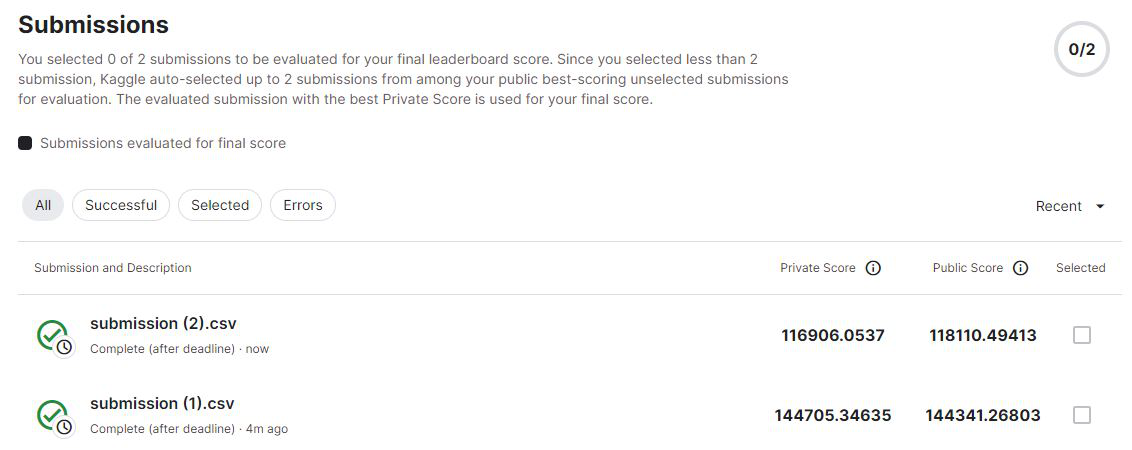

In [179]:
img = Image.open("Capture0.JPG")
img.show()

아래의 submission(1)이 중간에 주석처리된  
date, zipcode, condition, long, yr_built 이 약한 상관관계를 가진다고 가정하고 지운 후 학습을 진행했던 결과로  
결과에 악영향을 미쳤기 때문에 원래대로 복구하였습니다   

In [180]:
#모델의 개선 후, 다시 피쳐쪽을 해보기로 함

from sklearn.metrics import mean_squared_error

In [181]:
#에러계산은 로컬에서 해보기로

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [267]:
#랜덤포레스트도 써봅니다
from sklearn.ensemble import RandomForestRegressor
rdforest = RandomForestRegressor(random_state=2019)
models.append({'model':rdforest, 'name':'RandomForest'})
models

[{'model': GradientBoostingRegressor(random_state=2019),
  'name': 'GradientBoosting'},
 {'model': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               random_state=2019, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None),
  'name': 'XGBoost'},
 {'model': LGBMRegressor(random_state=2019), 'name': 'LightGBM'},
 {'model': RandomForestRegressor(random_state=2019), 'name': 'RandomForest'}]

In [191]:
#그리드서치도 써봅시다
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [192]:
result_gboost = my_GridSearch(gboost, x, y, param_grid)
result_gboost

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.029619,0.172101
2,10,50,-0.030005,0.173218
1,1,100,-0.055039,0.234604
0,1,50,-0.073256,0.270658


In [193]:
result_xgboost = my_GridSearch(xgboost, x, y, param_grid)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

In [194]:
result_lightgbm = my_GridSearch(lightgbm, x, y, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [195]:
result_rdforest = my_GridSearch(rdforest, x, y, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [196]:
result_xgboost

,max_depth,n_estimators,score,RMSLE
2,10,50,-0.030353,0.174220
3,10,100,-0.030476,0.174573
1,1,100,-0.043045,0.207474
0,1,50,-0.048744,0.220780


In [197]:
result_lightgbm

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027024,0.164391
2,10,50,-0.029174,0.170804
1,1,100,-0.055024,0.234571
0,1,50,-0.073398,0.270920


In [198]:
result_rdforest

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.035044,0.187202
2,10,50,-0.035295,0.187870
0,1,50,-0.176741,0.420405
1,1,100,-0.177703,0.421549


[CV] END .......................max_depth=1, n_estimators=50; total time=   3.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   5.6s
[CV] END ......................max_depth=10, n_estimators=50; total time=  25.9s
[CV] END .....................max_depth=10, n_estimators=100; total time=  51.5s
[CV] END .......................max_depth=1, n_estimators=50; total time=   3.4s
[CV] END ......................max_depth=1, n_estimators=100; total time=   9.2s
[CV] END ......................max_depth=10, n_estimators=50; total time= 1.1min
[CV] END .....................max_depth=10, n_estimators=100; total time= 1.5min
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.6s
[CV] END ......................max_depth=10, n_estimators=50; total time=   1.1s
[CV] END .....................max_depth=10, n_estimators=100; total time=   2.0s
[CV] END .......................max_depth=1, n_estimators=50; total time=   2.4s
[CV] END ...................

가장 좋은 모델은 lightgbm의 max depth 10 / n_estimators 100이었음  
이 옵션으로 모델을 학습시킨 후, 프레딕션 결과를 제출해보겠습니다


In [277]:
sub #테스트셋

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,1.386294,2.25,7.852050,8.887791,2.0,0,0,3,7,7.682943,5.993961,1951,1991,98125,47.7210,-122.319,7.433075,8.941153
1,201412,1.609438,3.00,7.581210,8.517393,1.0,0,0,5,7,6.957497,6.814543,1965,0,98136,47.5208,-122.393,7.215975,8.517393
2,201405,1.609438,4.50,8.598036,11.532051,1.0,0,0,3,11,8.266421,7.333676,2001,0,98053,47.6561,-122.005,8.468213,11.532051
3,201504,1.386294,1.00,7.484930,8.918784,1.0,0,0,3,7,6.957497,6.594413,1960,0,98146,47.5123,-122.337,7.484930,9.001346
4,201503,1.386294,2.50,7.544861,8.788898,2.0,0,0,3,7,7.544861,0.000000,2003,0,98038,47.3684,-122.031,7.779467,8.932080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,1.386294,1.75,7.313887,9.390075,1.0,0,0,3,6,7.313887,0.000000,2014,0,98010,47.3095,-122.002,7.186144,9.332912
6464,201501,1.386294,2.00,7.307202,7.027315,3.0,0,0,3,8,7.307202,0.000000,2014,0,98144,47.5699,-122.288,7.244942,7.115582
6465,201502,1.386294,2.50,7.178545,7.166266,2.0,0,0,3,8,7.074117,4.875197,2008,0,98116,47.5773,-122.409,7.193686,7.143618
6466,201406,1.098612,0.75,6.928538,7.208600,2.0,0,0,3,7,6.928538,0.000000,2009,0,98144,47.5944,-122.299,6.928538,7.604894


In [268]:

model = lgb.LGBMRegressor(max_depth=10, n_estimators=100, random_state=2019)
model.fit(x.values, y)
prediction = model.predict(sub.values)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [273]:
prediction = np.expm1(prediction)

In [274]:
submission = pd.DataFrame(data={'id':sub_id,'price':prediction})
submission

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05
...,...,...
6463,21498,2.328743e+05
6464,21499,4.038553e+05
6465,21500,4.495159e+05
6466,21501,3.274029e+05


In [275]:
submission.to_csv('submission.csv', index=False)

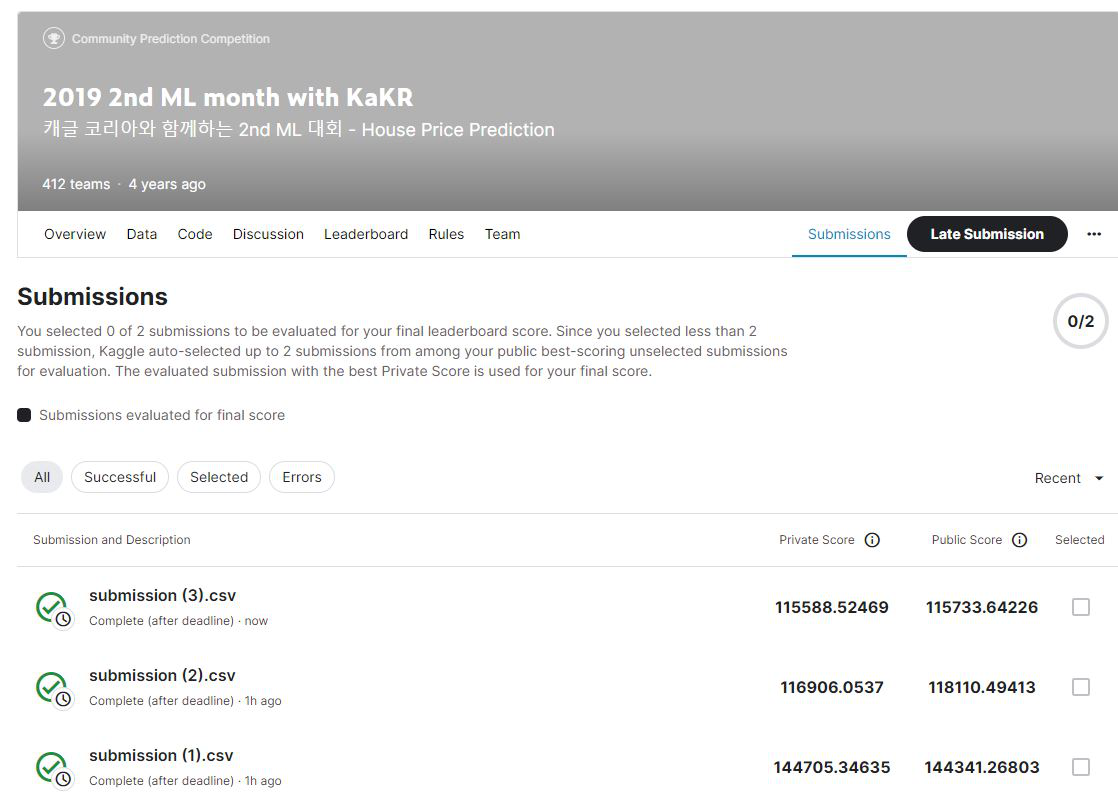

In [276]:
img = Image.open("Capture2.JPG")
img.show()

아주 소량의 개선이 있었지만, 목표 루브릭 11만점 이하 달성에는 실패하였습니다  
  
#회고  
  
### 미리 했어야 했는데, 너무 시간에 쫒겨서 했습니다 스스로에게 너무 화가납니다 ㅠㅠ
### 피쳐 엔지니어링은 민감하게 다뤄야 할 조심스러운 사항이라는 것을 많이 배운 것 같습니다
### 시각화는 직관적이지만, 정확한 수치를 통해 피쳐의 특성을 파악하는 것이 때로는 더 와닿을 수 있는 것 같습니다
